In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error



In [12]:
# Crear variables retardadas (lags)
def crear_lags(df, col, nlags):
    for i in range(1, nlags + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)
    return df# Generar datos sintéticos: una serie con un patrón cíclico
np.random.seed(0)
n = 200
t = np.arange(n)
serie = np.sin(2 * np.pi * t / 25) + np.random.normal(0, 0.3, n)  # patrón cíclico con ruido

# Introducir anomalías (ciclos "malos")
serie[80:85] += 3
serie[150:155] -= 3

# Crear DataFrame
df = pd.DataFrame({'valor': serie})



df = crear_lags(df, 'valor', 5)
df = df.dropna()

# Separar variables
X = df[[f'valor_lag_{i}' for i in range(1, 6)]].values
y = df['valor'].values

# Entrenar modelo de regresión
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Calcular error absoluto
error = np.abs(y - y_pred)
umbral = np.percentile(error, 95)  # Umbral del 95%

# Detectar ciclos malos
ciclos_malos = error > umbral

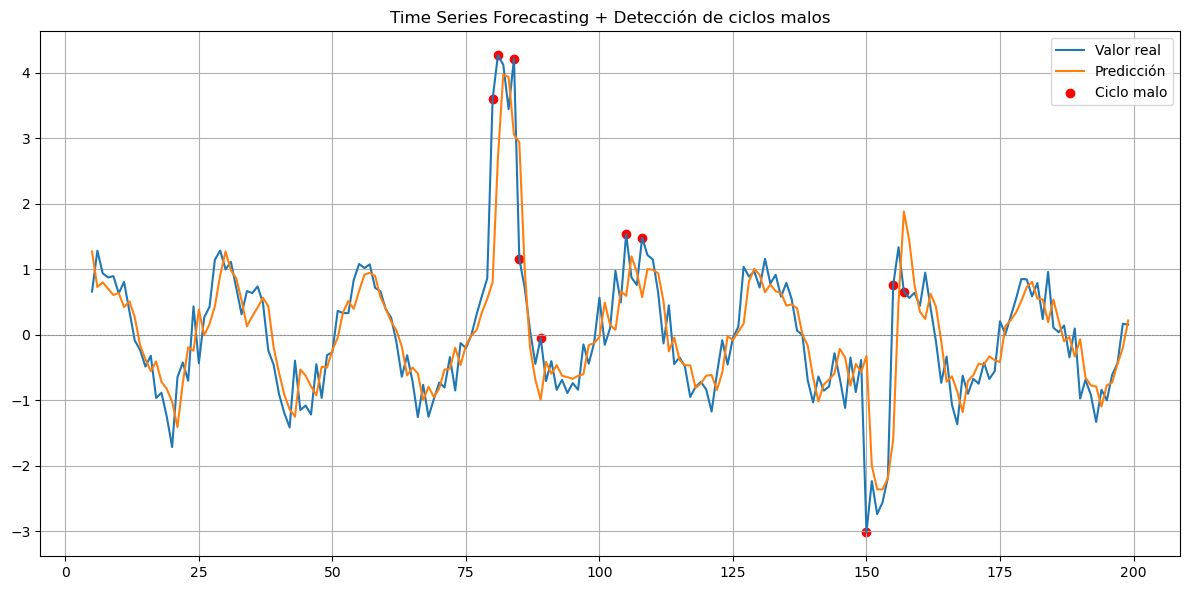

In [13]:
# Plot resultados
plt.figure(figsize=(12,6))
plt.plot(df.index, y, label='Valor real')
plt.plot(df.index, y_pred, label='Predicción')
plt.scatter(df.index[ciclos_malos], y[ciclos_malos], color='red', label='Ciclo malo')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Time Series Forecasting + Detección de ciclos malos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

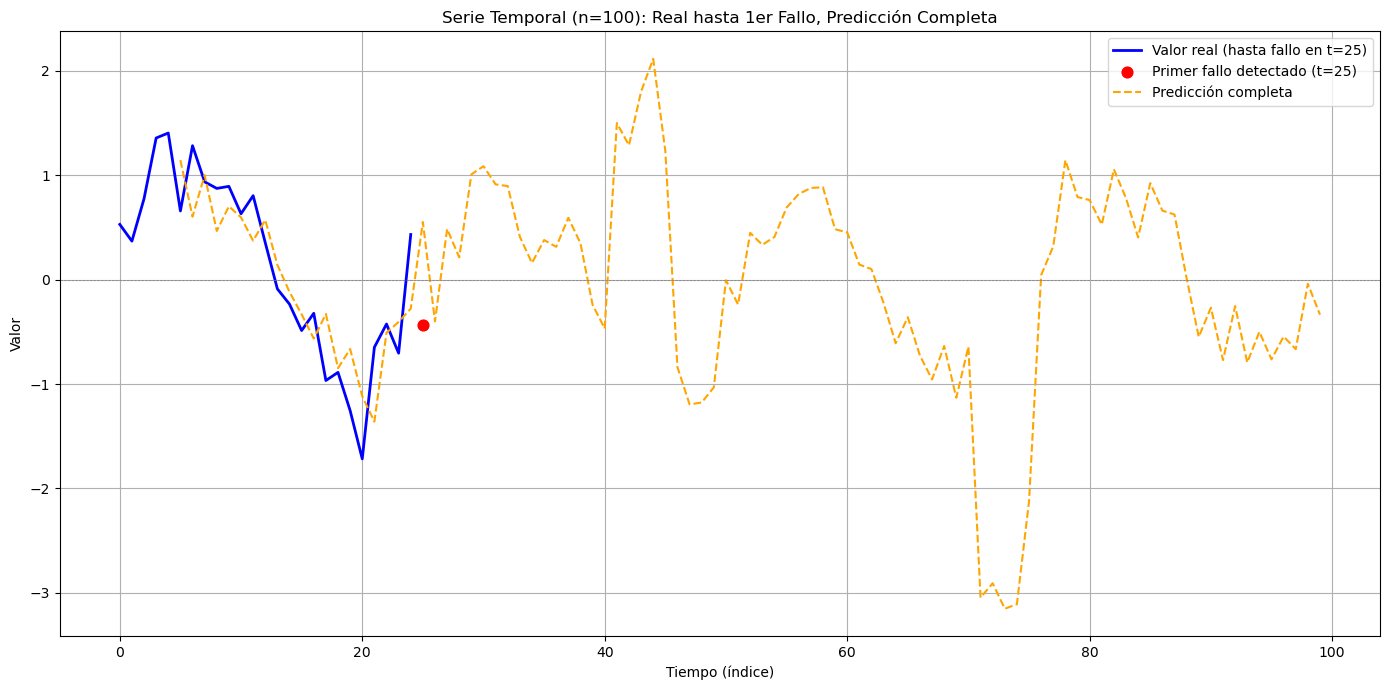

Longitud de la serie original: 100 puntos
Índice del primer (y único mostrado) ciclo malo detectado: 25


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# ----------------------------------------------------
# PARÁMETROS (igual que antes)
# ----------------------------------------------------
np.random.seed(0)
n = 100
t = np.arange(n)
serie = np.sin(2 * np.pi * t / 25) + np.random.normal(0, 0.3, n)

indices_anomalia_original_1 = np.arange(40, 45)
indices_anomalia_original_2 = np.arange(70, 75)
serie[indices_anomalia_original_1] += 3
serie[indices_anomalia_original_2] -= 3
# ----------------------------------------------------

# Crear DataFrame
df = pd.DataFrame({'valor': serie}, index=t)

# Crear variables retardadas (lags)
def crear_lags(df, col, nlags):
    df_copy = df.copy()
    for i in range(1, nlags + 1):
        df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
    return df_copy

nlags = 5
df_lags = crear_lags(df, 'valor', nlags)
df_lags = df_lags.dropna()

# Separar variables para el modelo
X = df_lags[[f'valor_lag_{i}' for i in range(1, nlags + 1)]].values
y = df_lags['valor'].values
indices_validos = df_lags.index

# Entrenar modelo y predecir
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X) # Predicciones para todos los índices válidos

# Calcular error y detectar anomalías (todos los puntos)
error = np.abs(y - y_pred)
umbral = np.percentile(error, 95)
ciclos_malos_detectados_bool = error > umbral
indices_ciclos_malos_detectados = indices_validos[ciclos_malos_detectados_bool]

# --- Lógica para el Plot ---
# Encontrar el índice del *primer* ciclo malo detectado
indice_primer_fallo = -1
if len(indices_ciclos_malos_detectados) > 0:
    indice_primer_fallo = indices_ciclos_malos_detectados[0]

# --- Plot resultados ---
plt.figure(figsize=(14, 7))

label_real = 'Valor real'
label_pred = 'Predicción completa' # La predicción siempre será completa

# 1. Plot valor real HASTA el primer fallo (si existe)
if indice_primer_fallo != -1:
    # CASO: Se detectó al menos un fallo
    indices_a_plotear_real = df.index < indice_primer_fallo
    plt.plot(df.index[indices_a_plotear_real], df['valor'][indices_a_plotear_real],
             label=f'{label_real} (hasta fallo en t={indice_primer_fallo})', linewidth=2, color='blue')

    # 3. Marcar SÓLO el primer ciclo malo detectado
    posicion_en_y = np.where(indices_validos == indice_primer_fallo)[0]
    if len(posicion_en_y) > 0:
        pos = posicion_en_y[0]
        plt.scatter([indice_primer_fallo], [y[pos]], # Usar valor real 'y' para la posición vertical
                    color='red', label=f'Primer fallo detectado (t={indice_primer_fallo})', zorder=5, s=60)
else:
    # CASO: No se detectaron fallos
    plt.plot(df.index, df['valor'], label=f'{label_real} (sin fallos detectados)', linewidth=2, color='blue')
    # No hay punto rojo que marcar

# 2. Plot TODAS las predicciones disponibles (HASTA EL FINAL) - Se hace siempre
plt.plot(indices_validos, y_pred, label=label_pred, linestyle='--', color='orange')


# Añadir línea de cero y otros detalles
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.title(f'Serie Temporal (n={n}): Real hasta 1er Fallo, Predicción Completa')
plt.xlabel('Tiempo (índice)')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar información sobre la detección (igual que antes)
print(f"Longitud de la serie original: {n} puntos")
# ... (resto de los prints informativos)
if indice_primer_fallo != -1:
    print(f"Índice del primer (y único mostrado) ciclo malo detectado: {indice_primer_fallo}")
else:
    print("No se detectaron ciclos malos según el umbral establecido.")

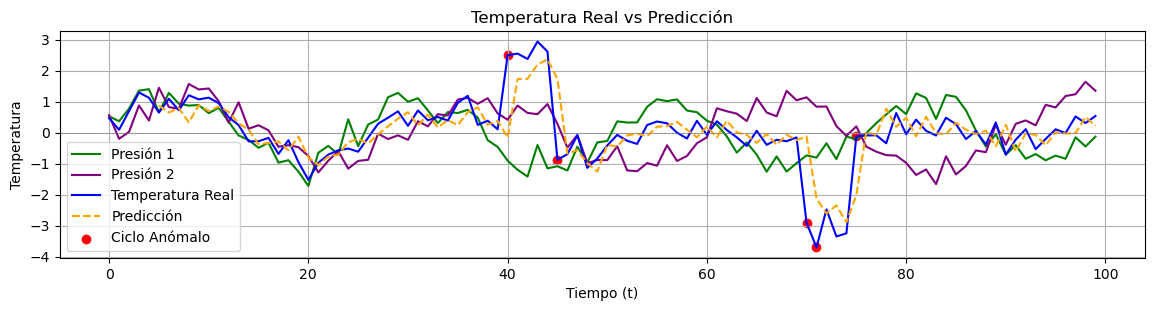

Total de anomalías detectadas: 5


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# ----------------------------------------------------
# PARÁMETROS
# ----------------------------------------------------
np.random.seed(0)
n = 100
t = np.arange(n)

# Generación de datos sintéticos: dos señales de presión y una de temperatura
presion1 = np.sin(2 * np.pi * t / 25) + np.random.normal(0, 0.3, n)
presion2 = np.sin(2 * np.pi * t / 30) + np.random.normal(0, 0.3, n)
temperatura = presion1 * 0.6 + presion2 * 0.4 + np.random.normal(0, 0.2, n)

# Introducir anomalías
indices_anomalia_1 = np.arange(40, 45)
indices_anomalia_2 = np.arange(70, 75)
temperatura[indices_anomalia_1] += 3
temperatura[indices_anomalia_2] -= 3

# Crear DataFrame
df = pd.DataFrame({'presion1': presion1, 'presion2': presion2, 'temperatura': temperatura}, index=t)

# Crear variables retardadas (lags)
def crear_lags(df, col, nlags):
    df_copy = df.copy()
    for i in range(1, nlags + 1):
        df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
    return df_copy

nlags = 5
df_lags = crear_lags(df, 'temperatura', nlags)
df_lags = df_lags.dropna()

# Separar variables para el modelo
X = df_lags[[f'temperatura_lag_{i}' for i in range(1, nlags + 1)]].values
y = df_lags['temperatura'].values
indices_validos = df_lags.index

# Entrenar modelo y predecir
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Calcular error y detectar anomalías
error = np.abs(y - y_pred)
umbral = np.percentile(error, 95)
ciclos_malos = error > umbral

# Plot resultados
plt.figure(figsize=(14, 10))

# Plot de las señales de presión
plt.subplot(3, 1, 1)
plt.plot(df.index, df['presion1'], label='Presión 1', color='green')
plt.plot(df.index, df['presion2'], label='Presión 2', color='purple')
plt.title('Señales de Presión')
plt.xlabel('Tiempo (t)')
plt.ylabel('Presión')
plt.legend()
plt.grid(True)

# Plot de la temperatura y predicción

plt.plot(df.index, df['temperatura'], label='Temperatura Real', color='blue')
plt.plot(indices_validos, y_pred, label='Predicción', linestyle='--', color='orange')
plt.scatter(indices_validos[ciclos_malos], y[ciclos_malos], color='red', label='Ciclo Anómalo')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Temperatura Real vs Predicción')
plt.xlabel('Tiempo (t)')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar información sobre la detección
total_anomalias = np.sum(ciclos_malos)
print(f'Total de anomalías detectadas: {total_anomalias}')


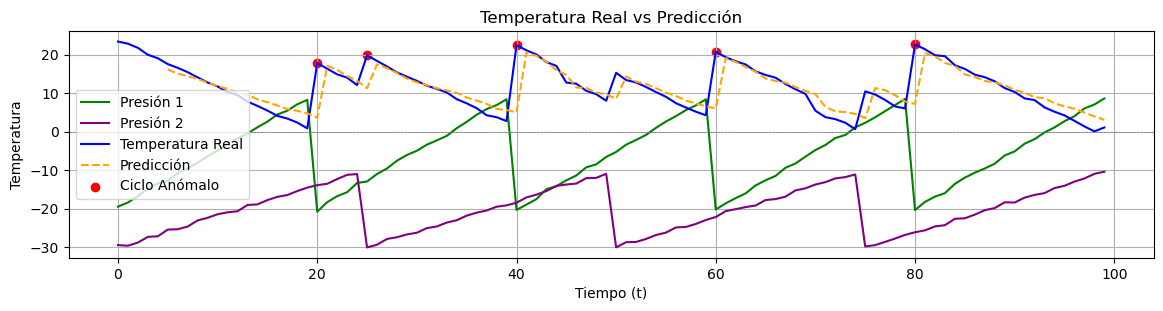

Total de anomalías detectadas: 5


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# ----------------------------------------------------
# PARÁMETROS
# ----------------------------------------------------
np.random.seed(0)
n = 100
t = np.arange(n)

# Generación de datos sintéticos: dos señales de presión y una de temperatura
presion1 = -5 + 15 * (2 * (t % 20) / 20 - 1) + np.random.normal(0, 0.3, n)
presion2 = -20 + 10 * (2 * (t % 25) / 25 - 1) + np.random.normal(0, 0.3, n)
temperatura = np.abs(presion1 * 0.6 + presion2 * 0.4) + np.random.normal(0, 0.2, n)

# Introducir anomalías
indices_anomalia_1 = np.arange(40, 45)
indices_anomalia_2 = np.arange(70, 75)
temperatura[indices_anomalia_1] += 3
temperatura[indices_anomalia_2] -= 3

# Crear DataFrame
df = pd.DataFrame({'presion1': presion1, 'presion2': presion2, 'temperatura': temperatura}, index=t)

# Crear variables retardadas (lags)
def crear_lags(df, col, nlags):
    df_copy = df.copy()
    for i in range(1, nlags + 1):
        df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
    return df_copy

nlags = 5
df_lags = crear_lags(df, 'temperatura', nlags)
df_lags = df_lags.dropna()

# Separar variables para el modelo
X = df_lags[[f'temperatura_lag_{i}' for i in range(1, nlags + 1)]].values
y = df_lags['temperatura'].values
indices_validos = df_lags.index

# Entrenar modelo y predecir
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Calcular error y detectar anomalías
error = np.abs(y - y_pred)
umbral = np.percentile(error, 95)
ciclos_malos = error > umbral

# Plot resultados
plt.figure(figsize=(14, 10))

# Plot de las señales de presión
plt.subplot(3, 1, 1)
plt.plot(df.index, df['presion1'], label='Presión 1', color='green')
plt.plot(df.index, df['presion2'], label='Presión 2', color='purple')
plt.title('Señales de Presión')
plt.xlabel('Tiempo (t)')
plt.ylabel('Presión')
plt.legend()
plt.grid(True)

# Plot de la temperatura y predicción

plt.plot(df.index, df['temperatura'], label='Temperatura Real', color='blue')
plt.plot(indices_validos, y_pred, label='Predicción', linestyle='--', color='orange')
plt.scatter(indices_validos[ciclos_malos], y[ciclos_malos], color='red', label='Ciclo Anómalo')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Temperatura Real vs Predicción')
plt.xlabel('Tiempo (t)')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar información sobre la detección
total_anomalias = np.sum(ciclos_malos)
print(f'Total de anomalías detectadas: {total_anomalias}')


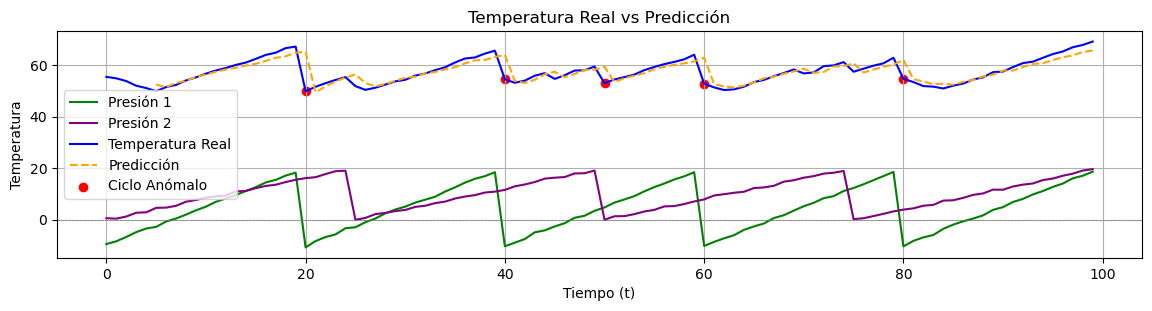

Total de anomalías detectadas: 5


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# ----------------------------------------------------
# PARÁMETROS
# ----------------------------------------------------
np.random.seed(0)
n = 100
t = np.arange(n)

# Generación de datos sintéticos: dos señales de presión y una de temperatura
presion1 = 5 + 15 * (2 * (t % 20) / 20 - 1) + np.random.normal(0, 0.3, n)
presion2 = 10 + 10 * (2 * (t % 25) / 25 - 1) + np.random.normal(0, 0.3, n)
temperatura = 50 + np.abs(presion1 * 0.6 + presion2 * 0.4) + np.random.normal(0, 0.2, n)

# Introducir anomalías
indices_anomalia_1 = np.arange(40, 45)
indices_anomalia_2 = np.arange(70, 75)
temperatura[indices_anomalia_1] += 3
temperatura[indices_anomalia_2] -= 3

# Crear DataFrame
df = pd.DataFrame({'presion1': presion1, 'presion2': presion2, 'temperatura': temperatura}, index=t)

# Crear variables retardadas (lags)
def crear_lags(df, col, nlags):
    df_copy = df.copy()
    for i in range(1, nlags + 1):
        df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
    return df_copy

nlags = 5
df_lags = crear_lags(df, 'temperatura', nlags)
df_lags = df_lags.dropna()

# Separar variables para el modelo
X = df_lags[[f'temperatura_lag_{i}' for i in range(1, nlags + 1)]].values
y = df_lags['temperatura'].values
indices_validos = df_lags.index

# Entrenar modelo y predecir
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Calcular error y detectar anomalías
error = np.abs(y - y_pred)
umbral = np.percentile(error, 95)
ciclos_malos = error > umbral

# Plot resultados
plt.figure(figsize=(14, 10))

# Plot de las señales de presión
plt.subplot(3, 1, 1)
plt.plot(df.index, df['presion1'], label='Presión 1', color='green')
plt.plot(df.index, df['presion2'], label='Presión 2', color='purple')
plt.title('Señales de Presión')
plt.xlabel('Tiempo (t)')
plt.ylabel('Presión')
plt.legend()
plt.grid(True)

# Plot de la temperatura y predicción

plt.plot(df.index, df['temperatura'], label='Temperatura Real', color='blue')
plt.plot(indices_validos, y_pred, label='Predicción', linestyle='--', color='orange')
plt.scatter(indices_validos[ciclos_malos], y[ciclos_malos], color='red', label='Ciclo Anómalo')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Temperatura Real vs Predicción')
plt.xlabel('Tiempo (t)')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar información sobre la detección
total_anomalias = np.sum(ciclos_malos)
print(f'Total de anomalías detectadas: {total_anomalias}')


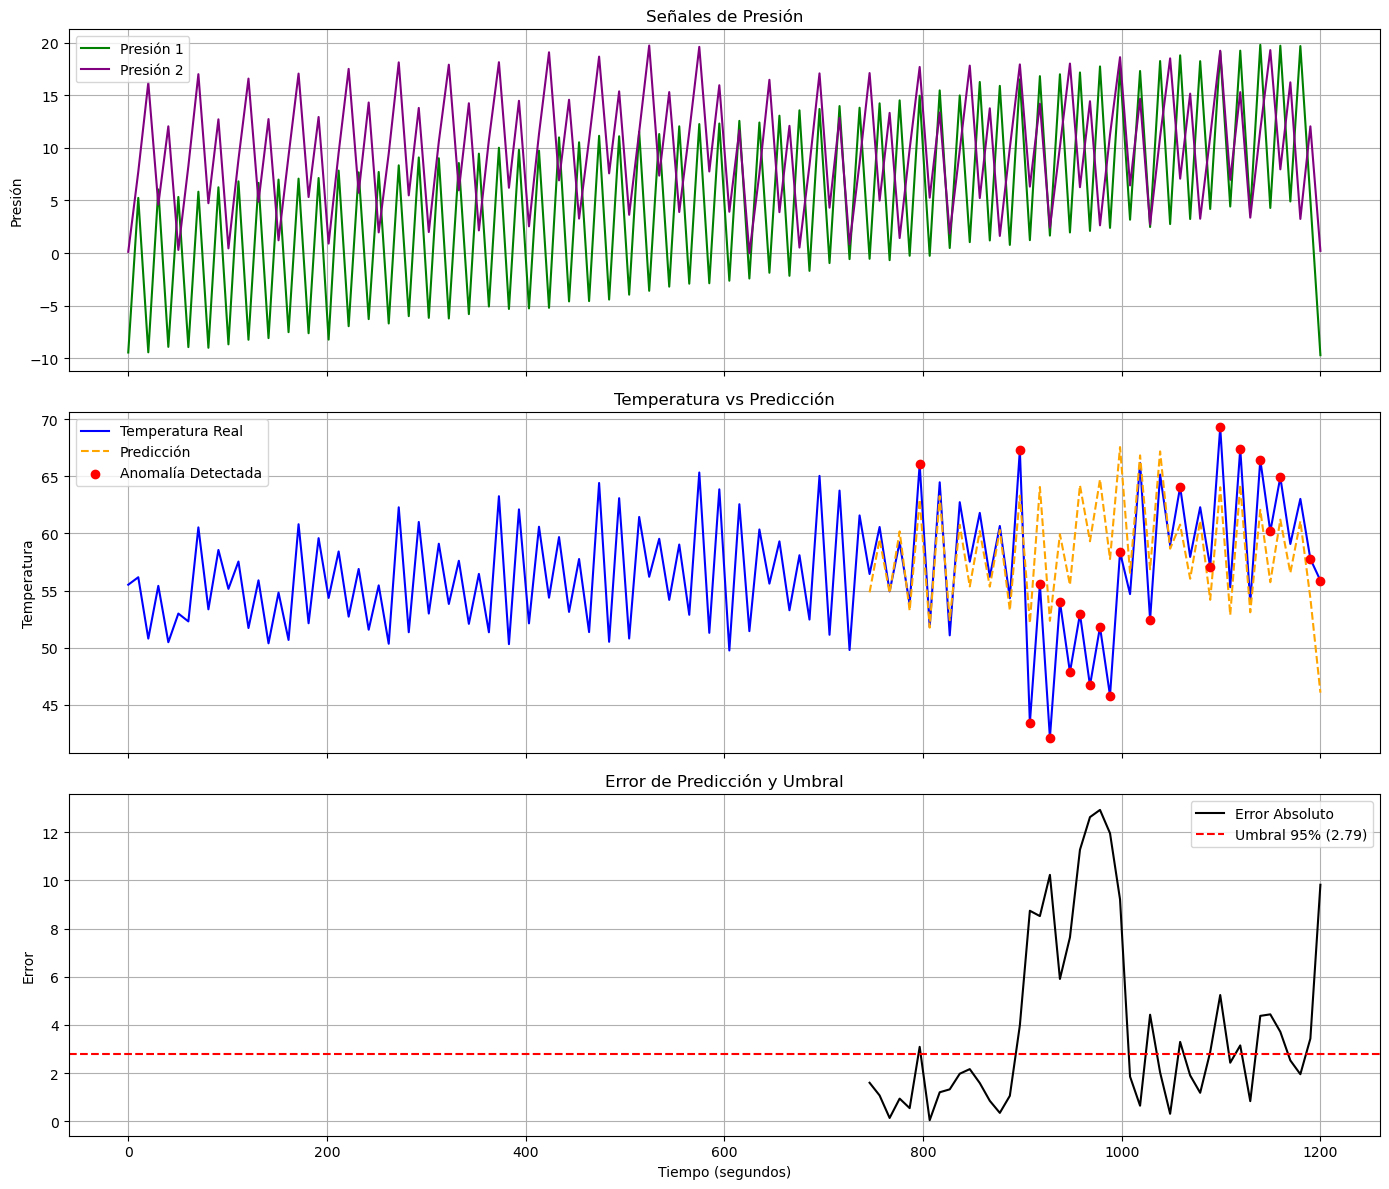

Umbral de error (percentil 95 del entrenamiento): 2.7925
Número de puntos anómalos detectados en test: 22
Primer punto anómalo detectado en t = 796.64 s


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ----------------------------------------------------
# PARÁMETROS GENERALES
# ----------------------------------------------------
np.random.seed(0)

# Número total de puntos (ciclo completo) y rango temporal
n = 120              # puntos totales (puedes ajustarlo)
t = np.linspace(0, 1200, n)  # 0 s → 1200 s (~20 min de ciclo)

# ----------------------------------------------------
# GENERACIÓN DE DATOS SINTÉTICOS
# ----------------------------------------------------
# Dos señales de presión (patrón de sierra) y una temperatura que depende de ambas
presion1 = 5 + 15 * (2 * (t % 20) / 20 - 1) + np.random.normal(0, 0.3, n)
presion2 = 10 + 10 * (2 * (t % 25) / 25 - 1) + np.random.normal(0, 0.3, n)

# La temperatura real de producción (positiva y más alta)
temperatura = 50 + np.abs(presion1 * 0.6 + presion2 * 0.4) + np.random.normal(0, 0.2, n)

# Introducir anomalías SOLO en la parte final del ciclo (para test)
indices_anomalia = np.arange(90, 100)
# Simulamos una caída repentina de temperatura anómala
temperatura[indices_anomalia] -= 10

# ----------------------------------------------------
# DATAFRAME Y LAGS DE TEMPERATURA
# ----------------------------------------------------
df = pd.DataFrame({
    'presion1': presion1,
    'presion2': presion2,
    'temperatura': temperatura
}, index=t)

def crear_lags(df, col, nlags):
    df_copy = df.copy()
    for i in range(1, nlags + 1):
        df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
    return df_copy

nlags = 5

# Creamos lags SOLO de temperatura (las presiones se usan en tiempo real)
df_lags = crear_lags(df, 'temperatura', nlags).dropna()

# ----------------------------------------------------
# TRAIN / TEST SPLIT (simulando ciclos "buenos" vs ciclo en producción)
# ----------------------------------------------------
split_idx = int(len(df_lags) * 0.6)  # ~60 % para entrenamiento
train_df = df_lags.iloc[:split_idx]
test_df  = df_lags.iloc[split_idx:]

# ----------------------------------------------------
# MATRICES DE CARACTERÍSTICAS Y OBJETIVO
# ----------------------------------------------------
feature_cols_lag = [f'temperatura_lag_{i}' for i in range(1, nlags + 1)]

X_train = np.column_stack((
    train_df['presion1'].values,
    train_df['presion2'].values,
    train_df[feature_cols_lag].values
))

y_train = train_df['temperatura'].values

X_test = np.column_stack((
    test_df['presion1'].values,
    test_df['presion2'].values,
    test_df[feature_cols_lag].values
))

y_test = test_df['temperatura'].values

# Índices temporales para gráficos
idx_train = train_df.index
idx_test  = test_df.index

# ----------------------------------------------------
# ENTRENAMIENTO DEL MODELO (ciclos normales)
# ----------------------------------------------------
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Threshold basado en error de entrenamiento (percentil 95)
y_pred_train = modelo.predict(X_train)
train_error  = np.abs(y_train - y_pred_train)
threshold    = np.percentile(train_error, 95)

# ----------------------------------------------------
# PREDICCIÓN EN "TIEMPO REAL" (datos de test)
# ----------------------------------------------------
y_pred_test = modelo.predict(X_test)

test_error  = np.abs(y_test - y_pred_test)
anomaly_mask = test_error > threshold

first_anomaly_time = None
if anomaly_mask.any():
    first_anomaly_time = idx_test[anomaly_mask][0]

# ----------------------------------------------------
# VISUALIZACIÓN
# ----------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1) Presiones
axes[0].plot(df.index, df['presion1'], label='Presión 1', color='green')
axes[0].plot(df.index, df['presion2'], label='Presión 2', color='purple')
axes[0].set_title('Señales de Presión')
axes[0].set_ylabel('Presión')
axes[0].legend()
axes[0].grid(True)

# 2) Temperatura real vs predicción
axes[1].plot(df.index, df['temperatura'], label='Temperatura Real', color='blue')
axes[1].plot(idx_test, y_pred_test, label='Predicción', linestyle='--', color='orange')
axes[1].scatter(idx_test[anomaly_mask], y_test[anomaly_mask], color='red', label='Anomalía Detectada', zorder=5)
axes[1].set_title('Temperatura vs Predicción')
axes[1].set_ylabel('Temperatura')
axes[1].legend()
axes[1].grid(True)

# 3) Error absoluto y umbral
axes[2].plot(idx_test, test_error, label='Error Absoluto', color='black')
axes[2].axhline(threshold, color='red', linestyle='--', label=f'Umbral 95% ({threshold:.2f})')
axes[2].set_title('Error de Predicción y Umbral')
axes[2].set_ylabel('Error')
axes[2].set_xlabel('Tiempo (segundos)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# RESUMEN EN CONSOLA
# ----------------------------------------------------
print(f"Umbral de error (percentil 95 del entrenamiento): {threshold:.4f}")
print(f"Número de puntos anómalos detectados en test: {anomaly_mask.sum()}")
if first_anomaly_time is not None:
    print(f"Primer punto anómalo detectado en t = {first_anomaly_time:.2f} s")


Coeficientes: [ 1.9910359  -0.85044746  3.55592504]
Intercepto  : 5.67
MAE         : 1.61
R²          : 0.975


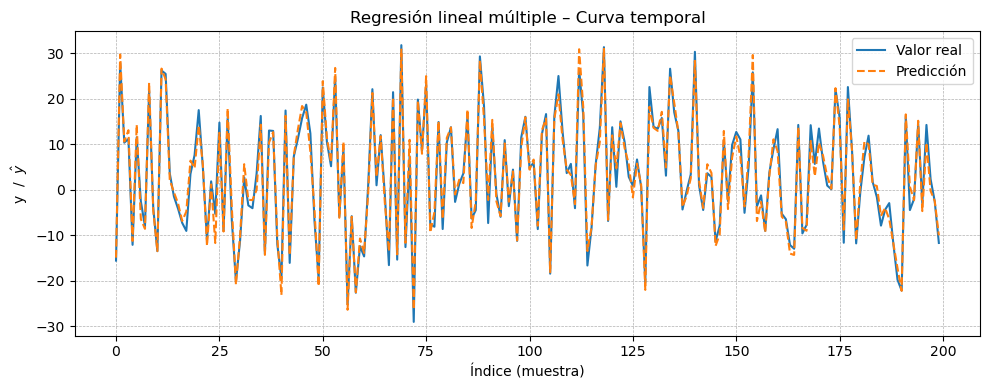

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Datos sintéticos -------------------------------------------------------
np.random.seed(42)
n = 200
X1 = np.random.uniform( 0, 10, n)
X2 = np.random.uniform(10, 20, n)
X3 = np.random.uniform(-5,  5, n)
y  = 2.0*X1 - 0.8*X2 + 3.5*X3 + 5 + np.random.normal(0, 2, n)

df = pd.DataFrame({'x1':X1, 'x2':X2, 'x3':X3, 'y':y})

# 2. Matrices de entrada / salida ------------------------------------------
X = df[['x1', 'x2', 'x3']].values
y = df['y'].values

# 3. Entrenamiento ----------------------------------------------------------
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

# 4. Métricas rápidas -------------------------------------------------------
print("Coeficientes:", linreg.coef_)
print("Intercepto  :", f"{linreg.intercept_:.2f}")
print("MAE         :", f"{mean_absolute_error(y, y_pred):.2f}")
print("R²          :", f"{r2_score(y, y_pred):.3f}")

# 5. Gráfico temporal Real vs Predicción -----------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y,      label='Valor real', linewidth=1.5)
plt.plot(y_pred, label='Predicción', linestyle='--', linewidth=1.5)
plt.title('Regresión lineal múltiple – Curva temporal')
plt.xlabel('Índice (muestra)')
plt.ylabel('y  /  $\hat{y}$')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


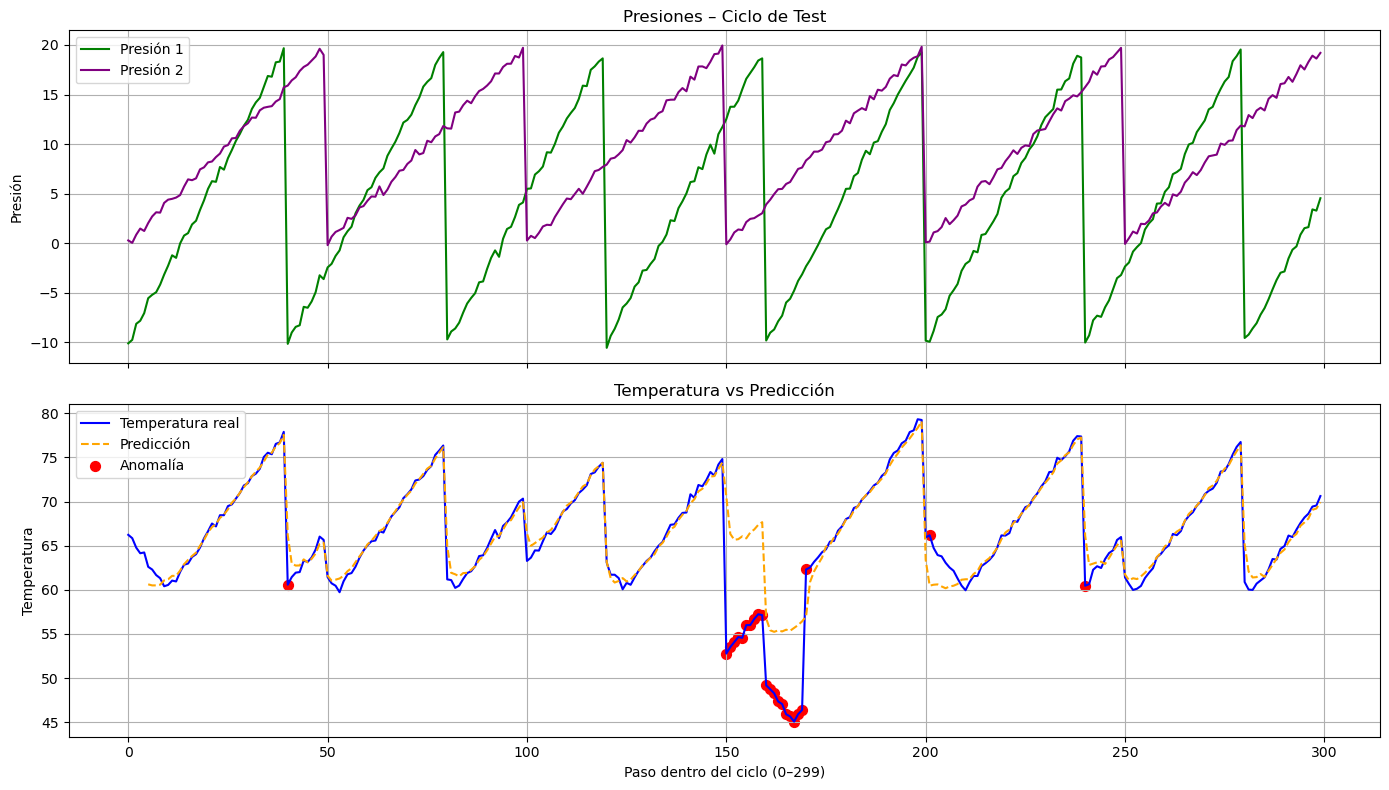

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ----------------------------------------------------
# 0. Parámetros
# ----------------------------------------------------
np.random.seed(42)
points_per_cycle          = 300
n_cycles_train            = 10
n_cycles_test             = 1
nlags                     = 5
anomaly_threshold_percent = 99

# ----------------------------------------------------
# 1. Generador de ciclos sintéticos
# ----------------------------------------------------
def generate_cycle(cycle_id, is_good=True, anomaly_pos=None):
    t  = np.arange(points_per_cycle)
    p1 = 5  + 15*(2*(t % 40)/40 - 1) + np.random.normal(0,0.3,points_per_cycle)
    p2 = 10 + 10*(2*(t % 50)/50 - 1) + np.random.normal(0,0.3,points_per_cycle)
    temp = 60 + np.abs(0.6*p1 + 0.4*p2) + np.random.normal(0,0.2,points_per_cycle)
    if not is_good and anomaly_pos is not None:
        temp[anomaly_pos:min(anomaly_pos+20, points_per_cycle)] -= 15
    return pd.DataFrame({
        "cycle_id"   : cycle_id,
        "t_in_cycle" : t,
        "presion1"   : p1,
        "presion2"   : p2,
        "temperatura": temp,
    })

# ----------------------------------------------------
# 2. Conjuntos de entrenamiento y prueba
# ----------------------------------------------------
df_train = pd.concat([generate_cycle(cid, True) for cid in range(n_cycles_train)],
                     ignore_index=True)
anom_pos = np.random.randint(20, points_per_cycle-20)
df_test  = generate_cycle(n_cycles_train, False, anom_pos)

# ----------------------------------------------------
# 3. Crear lags (solo temperatura)
# ----------------------------------------------------
def create_lags(df, target, nlags):
    out = df.copy()
    for i in range(1, nlags+1):
        out[f"{target}_lag_{i}"] = out.groupby("cycle_id")[target].shift(i)
    return out.dropna()

df_train_lags = create_lags(df_train, "temperatura", nlags)
df_test_lags  = create_lags(df_test,  "temperatura", nlags)
lag_cols = [f"temperatura_lag_{i}" for i in range(1, nlags+1)]

# ----------------------------------------------------
# 4. Matrices de features y etiquetas
# ----------------------------------------------------
X_train = np.column_stack([
    df_train_lags["presion1"].values,
    df_train_lags["presion2"].values,
    df_train_lags[lag_cols].values,
])
y_train = df_train_lags["temperatura"].values

X_test = np.column_stack([
    df_test_lags["presion1"].values,
    df_test_lags["presion2"].values,
    df_test_lags[lag_cols].values,
])
y_test = df_test_lags["temperatura"].values
idx_test = df_test_lags["t_in_cycle"]

# ----------------------------------------------------
# 5. Entrenamiento y umbral
# ----------------------------------------------------
reg = LinearRegression().fit(X_train, y_train)
train_err = np.abs(y_train - reg.predict(X_train))
threshold = np.percentile(train_err, anomaly_threshold_percent)

# ----------------------------------------------------
# 6. Predicción y detección en el ciclo de test
# ----------------------------------------------------
pred_test = reg.predict(X_test)
err_test  = np.abs(y_test - pred_test)
anom_mask = err_test > threshold

# ----------------------------------------------------
# 7. Plot: solo los dos paneles solicitados
# ----------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# (a) Presiones
axes[0].plot(df_test["t_in_cycle"], df_test["presion1"], label="Presión 1", color="green")
axes[0].plot(df_test["t_in_cycle"], df_test["presion2"], label="Presión 2", color="purple")
axes[0].set_ylabel("Presión")
axes[0].set_title("Presiones – Ciclo de Test")
axes[0].legend(); axes[0].grid(True)

# (b) Temperatura real vs predicción (con anomalías)
axes[1].plot(df_test["t_in_cycle"], df_test["temperatura"],
             label="Temperatura real", color="blue")
axes[1].plot(idx_test, pred_test,
             label="Predicción", linestyle="--", color="orange")
if anom_mask.any():
    axes[1].scatter(idx_test[anom_mask], y_test[anom_mask],
                    color="red", s=50, label="Anomalía")
axes[1].set_xlabel("Paso dentro del ciclo (0–299)")
axes[1].set_ylabel("Temperatura")
axes[1].set_title("Temperatura vs Predicción")
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


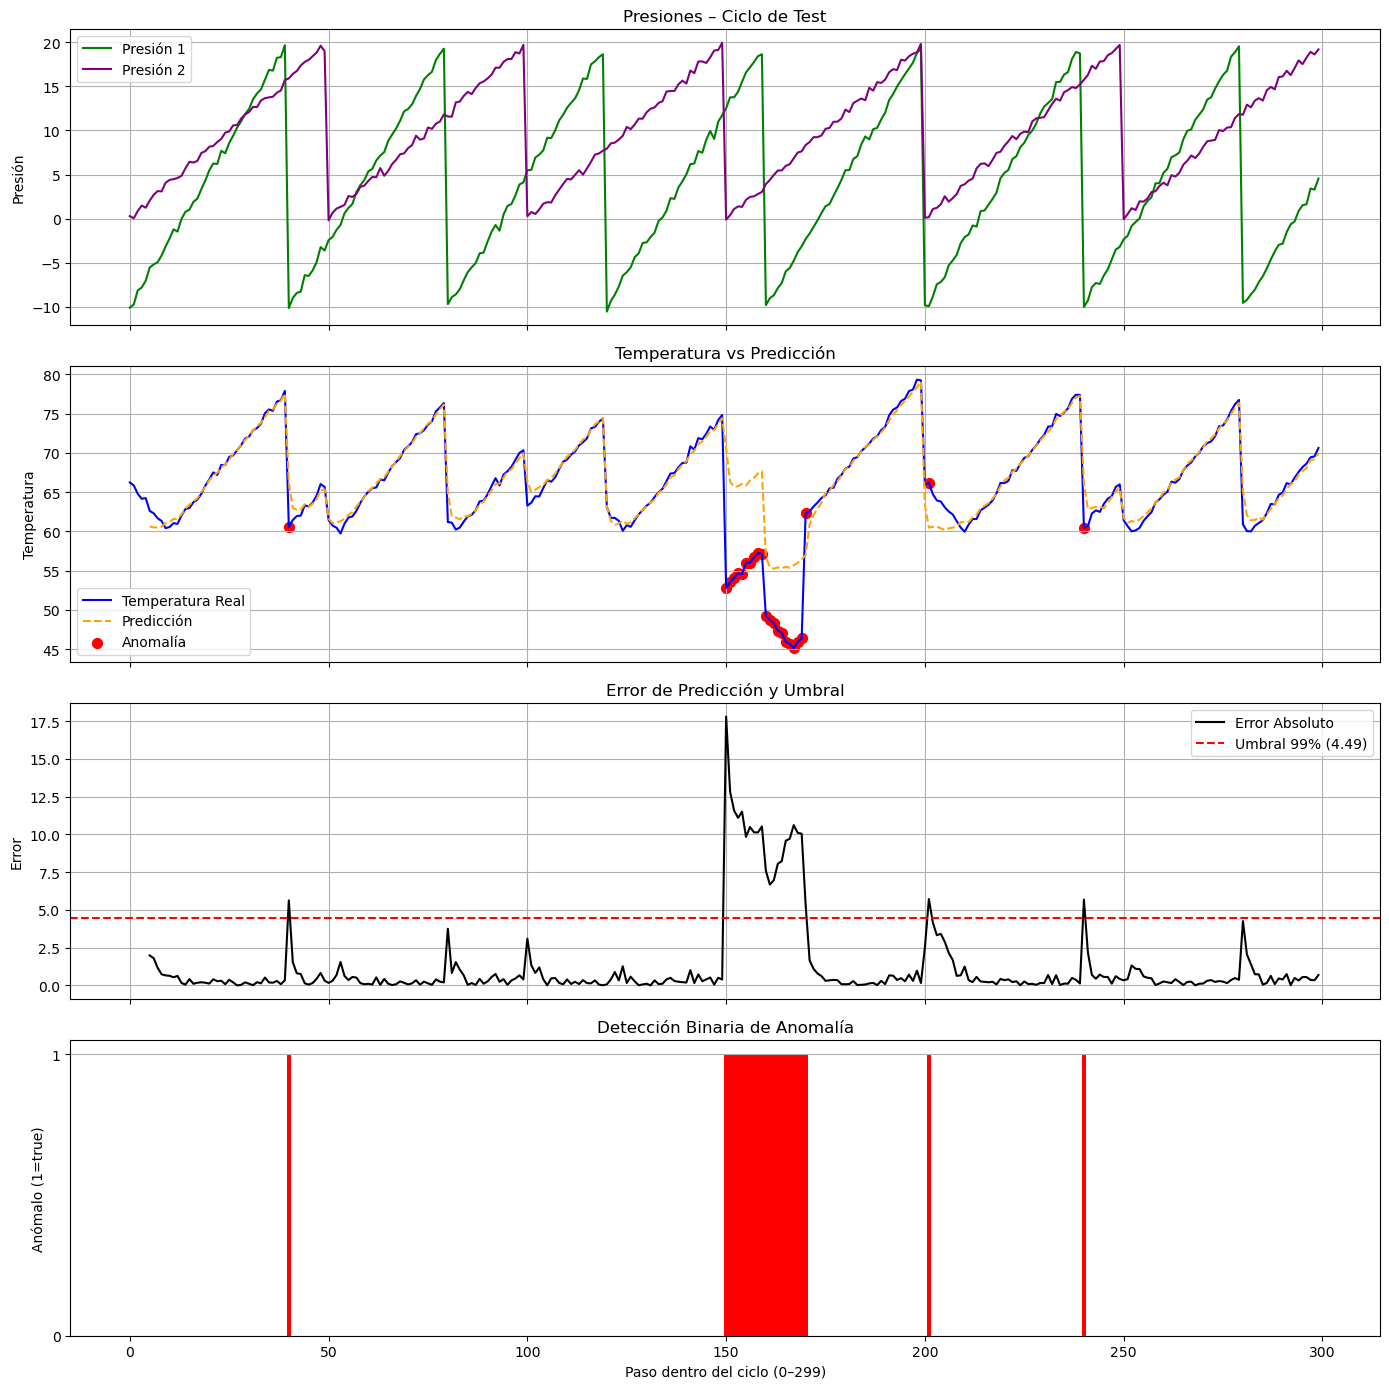

Umbral (p99) de error: 4.490
Puntos anómalos detectados: 24 / 295
⚠️  Primera anomalía en paso 40 del ciclo


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

"""
Detección de anomalías en ciclos industriales.
- Cada ciclo tiene 300 muestras (puntos), con patrones de presión repetitivos.
- Entrenamos el modelo únicamente con ciclos "buenos" (normales).
- Probamos en 1 ciclo donde la anomalía puede aparecer en cualquier instante
  (20, 170, 220, ...). El algoritmo debe levantar la alerta lo antes posible.
"""

# -----------------------------------------------------------------------------
# 0. PARÁMETROS
# -----------------------------------------------------------------------------
np.random.seed(42)
points_per_cycle          = 300   # muestras por ciclo
n_cycles_train            = 10    # ciclos normales para entrenamiento
n_cycles_test             = 1     # ciclos para test (con posible anomalía)
nlags                     = 5     # lags de temperatura dentro de cada ciclo
anomaly_threshold_percent = 99    # percentil para el umbral de error

# -----------------------------------------------------------------------------
# 1. FUNCIÓN DE GENERACIÓN DE UN CICLO
# -----------------------------------------------------------------------------

def generate_cycle(cycle_id: int, is_good: bool = True, anomaly_pos: int | None = None):
    """Genera un ciclo sintético con 2 presiones en forma de sierra y 1 temperatura.
    Si ``is_good`` es False, inserta una anomalía de temperatura en ``anomaly_pos``.
    """
    t = np.arange(points_per_cycle)
    # Patrón de presión en diente de sierra + ruido
    p1 = 5  + 15 * (2 * (t % 40) / 40 - 1) + np.random.normal(0, 0.3, points_per_cycle)
    p2 = 10 + 10 * (2 * (t % 50) / 50 - 1) + np.random.normal(0, 0.3, points_per_cycle)
    # Temperatura alta y positiva con dependencia no lineal de ambas presiones
    temp = 60 + np.abs(0.6 * p1 + 0.4 * p2) + np.random.normal(0, 0.2, points_per_cycle)

    # Insertar anomalía: caída brusca de temperatura durante 20 muestras
    if not is_good and anomaly_pos is not None:
        end_anom = min(anomaly_pos + 20, points_per_cycle)
        temp[anomaly_pos:end_anom] -= 15  # p.ej. rotura de bolsa → pérdida de calor

    return pd.DataFrame({
        "cycle_id"   : cycle_id,
        "t_in_cycle": t,      # índice interno del ciclo
        "presion1"  : p1,
        "presion2"  : p2,
        "temperatura": temp,
    })

# -----------------------------------------------------------------------------
# 2. CONSTRUIR DATASETS DE ENTRENAMIENTO Y PRUEBA
# -----------------------------------------------------------------------------
train_cycles = [generate_cycle(cid, is_good=True) for cid in range(n_cycles_train)]

df_train = pd.concat(train_cycles, ignore_index=True)

# CICLO DE TEST con anomalía en posición aleatoria (evitar extremos del ciclo)
anom_pos = np.random.randint(20, points_per_cycle - 20)

df_test = generate_cycle(n_cycles_train, is_good=False, anomaly_pos=anom_pos)

# -----------------------------------------------------------------------------
# 3. CREAR LAGS DE TEMPERATURA (sin cruzar ciclos)
# -----------------------------------------------------------------------------

def create_lags(df: pd.DataFrame, target: str, nlags: int):
    df_lags = df.copy()
    for i in range(1, nlags + 1):
        df_lags[f"{target}_lag_{i}"] = df_lags.groupby("cycle_id")[target].shift(i)
    return df_lags.dropna()

df_train_lags = create_lags(df_train, "temperatura", nlags)
df_test_lags  = create_lags(df_test,  "temperatura", nlags)

feature_cols_lag = [f"temperatura_lag_{i}" for i in range(1, nlags + 1)]

# -----------------------------------------------------------------------------
# 4. MATRICES DE FEATURES Y LABELS
# -----------------------------------------------------------------------------
X_train = np.column_stack((
    df_train_lags["presion1"].values,
    df_train_lags["presion2"].values,
    df_train_lags[feature_cols_lag].values,
))
y_train = df_train_lags["temperatura"].values
idx_train = df_train_lags[["cycle_id", "t_in_cycle"]]

X_test = np.column_stack((
    df_test_lags["presion1"].values,
    df_test_lags["presion2"].values,
    df_test_lags[feature_cols_lag].values,
))
y_test = df_test_lags["temperatura"].values
idx_test = df_test_lags[["cycle_id", "t_in_cycle"]]

# -----------------------------------------------------------------------------
# 5. ENTRENAR MODELO Y DEFINIR UMBRAL
# -----------------------------------------------------------------------------
reg = LinearRegression()
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
train_err  = np.abs(y_train - pred_train)
threshold  = np.percentile(train_err, anomaly_threshold_percent)

# -----------------------------------------------------------------------------
# 6. DETECCIÓN EN EL CICLO DE TEST
# -----------------------------------------------------------------------------
pred_test = reg.predict(X_test)
err_test  = np.abs(y_test - pred_test)
anom_mask = err_test > threshold
first_anom_step = idx_test[anom_mask].iloc[0]["t_in_cycle"] if anom_mask.any() else None

# -----------------------------------------------------------------------------
# 7. VISUALIZAR RESULTADOS DEL CICLO DE TEST
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
cycle_time = df_test["t_in_cycle"].values

# (a) Presiones
a1 = axes[0]
a1.plot(cycle_time, df_test["presion1"], label="Presión 1", color="green")
a1.plot(cycle_time, df_test["presion2"], label="Presión 2", color="purple")
a1.set_ylabel("Presión")
a1.set_title("Presiones – Ciclo de Test")
a1.legend(); a1.grid(True)

# (b) Temperatura real vs predicción
a2 = axes[1]
a2.plot(cycle_time, df_test["temperatura"], label="Temperatura Real", color="blue")
a2.plot(idx_test["t_in_cycle"], pred_test, label="Predicción", linestyle="--", color="orange")
if anom_mask.any():
    anomaly_times = idx_test["t_in_cycle"][anom_mask]
    a2.scatter(anomaly_times, y_test[anom_mask], color="red", s=50, label="Anomalía")
a2.set_ylabel("Temperatura")
a2.set_title("Temperatura vs Predicción")
a2.legend(); a2.grid(True)

# (c) Error absoluto + umbral
a3 = axes[2]
a3.plot(idx_test["t_in_cycle"], err_test, label="Error Absoluto", color="black")
a3.axhline(threshold, color="red", linestyle="--", label=f"Umbral {anomaly_threshold_percent}% ({threshold:.2f})")
a3.set_ylabel("Error")
a3.set_title("Error de Predicción y Umbral")
a3.legend(); a3.grid(True)

# (d) Máscara de anomalía (0/1) como barra
anomaly_indicator = np.zeros_like(err_test)
anomaly_indicator[anom_mask] = 1
a4 = axes[3]
a4.bar(idx_test["t_in_cycle"], anomaly_indicator, width=1, color="red")
a4.set_ylabel("Anómalo (1=true)")
a4.set_xlabel("Paso dentro del ciclo (0–299)")
a4.set_title("Detección Binaria de Anomalía")
a4.set_yticks([0, 1])
a4.grid(True, axis="y")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 8. RESUMEN EN CONSOLA
# -----------------------------------------------------------------------------
print(f"Umbral (p{anomaly_threshold_percent}) de error: {threshold:.3f}")
print(f"Puntos anómalos detectados: {anom_mask.sum()} / {len(err_test)}")
if first_anom_step is not None:
    print(f"⚠️  Primera anomalía en paso {first_anom_step} del ciclo")
else:
    print("Sin anomalías detectadas en el ciclo de test")


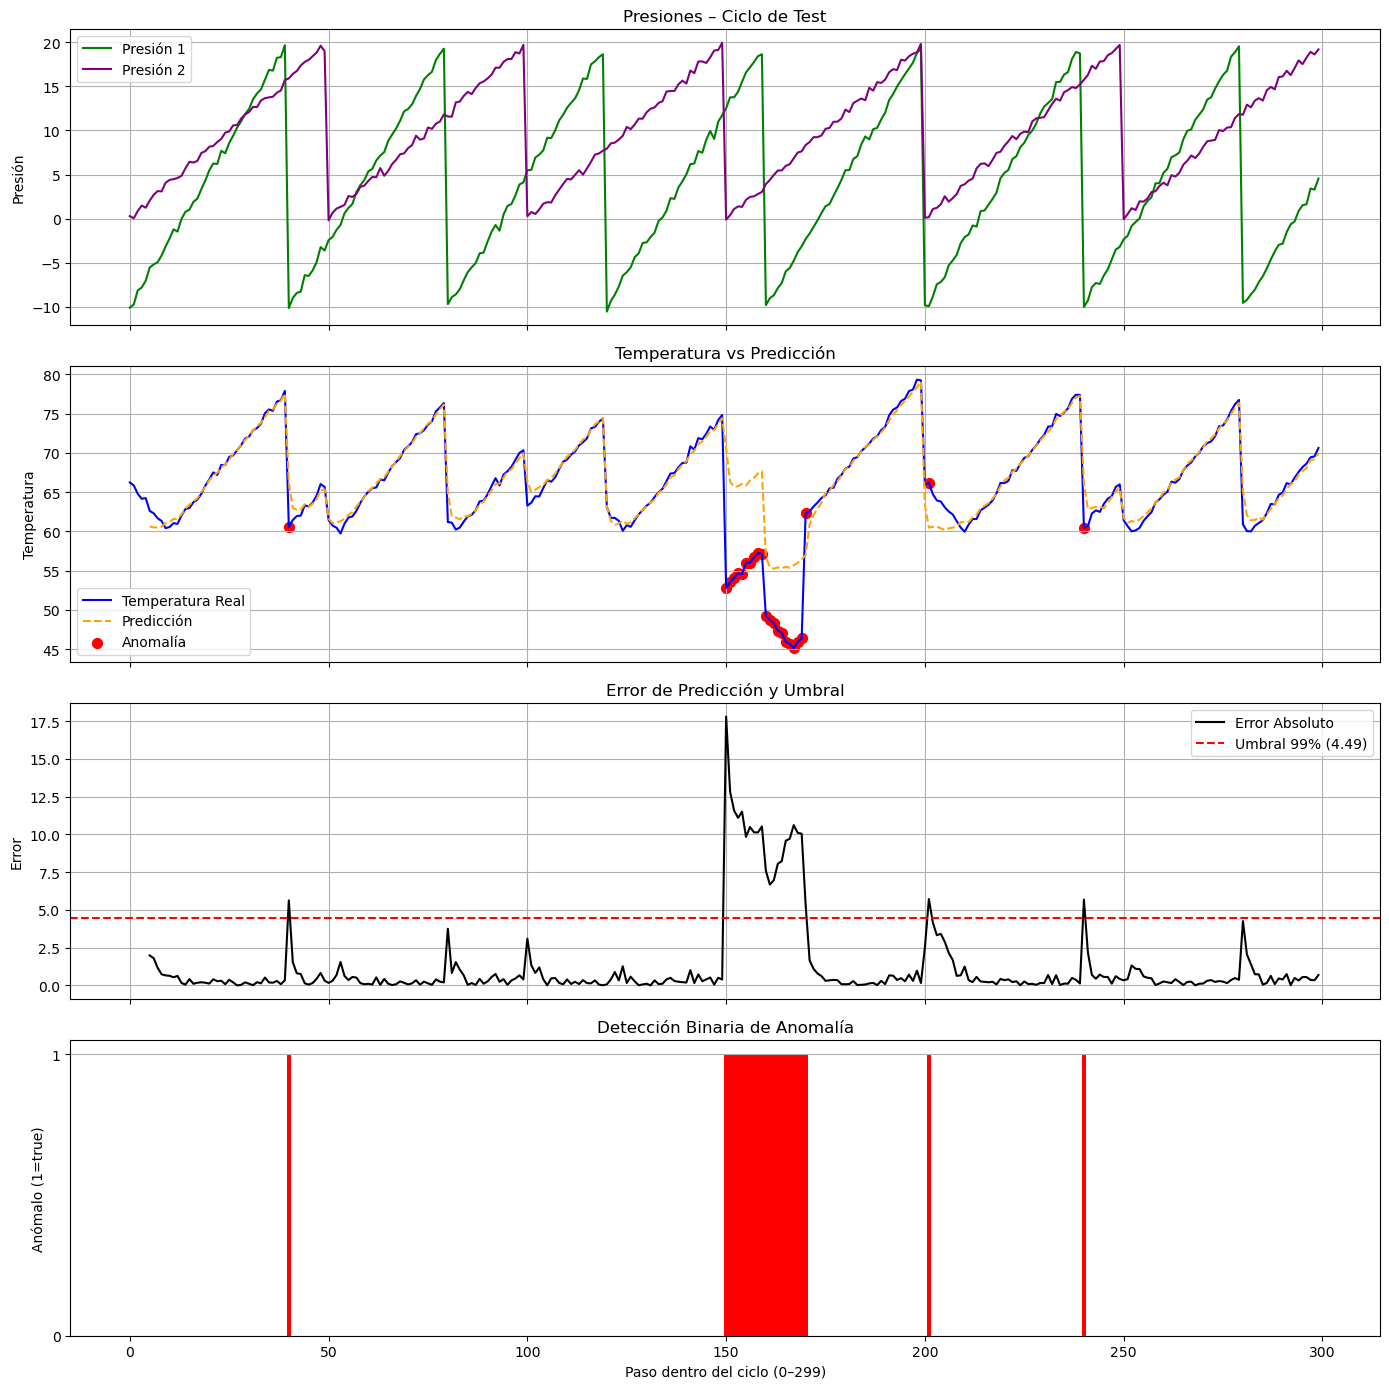

Umbral (p99) de error: 4.490
Puntos anómalos detectados: 24 / 295
⚠️  Primera anomalía en paso 40 del ciclo


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

"""
Detección de anomalías en ciclos industriales.
- Cada ciclo tiene 300 muestras (puntos), con patrones de presión repetitivos.
- Entrenamos el modelo únicamente con ciclos "buenos" (normales).
- Probamos en 1 ciclo donde la anomalía puede aparecer en cualquier instante
  (20, 170, 220, ...). El algoritmo debe levantar la alerta lo antes posible.
"""

# -----------------------------------------------------------------------------
# 0. PARÁMETROS
# -----------------------------------------------------------------------------
np.random.seed(42)
points_per_cycle          = 300   # muestras por ciclo
n_cycles_train            = 10    # ciclos normales para entrenamiento
n_cycles_test             = 1     # ciclos para test (con posible anomalía)
nlags                     = 5     # lags de temperatura dentro de cada ciclo
anomaly_threshold_percent = 99    # percentil para el umbral de error

# -----------------------------------------------------------------------------
# 1. FUNCIÓN DE GENERACIÓN DE UN CICLO
# -----------------------------------------------------------------------------

def generate_cycle(cycle_id: int, is_good: bool = True, anomaly_pos: int | None = None):
    """Genera un ciclo sintético con 2 presiones en forma de sierra y 1 temperatura.
    Si ``is_good`` es False, inserta una anomalía de temperatura en ``anomaly_pos``.
    """
    t = np.arange(points_per_cycle)
    # Patrón de presión en diente de sierra + ruido
    p1 = 5  + 15 * (2 * (t % 40) / 40 - 1) + np.random.normal(0, 0.3, points_per_cycle)
    p2 = 10 + 10 * (2 * (t % 50) / 50 - 1) + np.random.normal(0, 0.3, points_per_cycle)
    # Temperatura alta y positiva con dependencia no lineal de ambas presiones
    temp = 60 + np.abs(0.6 * p1 + 0.4 * p2) + np.random.normal(0, 0.2, points_per_cycle)

    # Insertar anomalía: caída brusca de temperatura durante 20 muestras
    if not is_good and anomaly_pos is not None:
        end_anom = min(anomaly_pos + 20, points_per_cycle)
        temp[anomaly_pos:end_anom] -= 15  # p.ej. rotura de bolsa → pérdida de calor

    return pd.DataFrame({
        "cycle_id"   : cycle_id,
        "t_in_cycle": t,      # índice interno del ciclo
        "presion1"  : p1,
        "presion2"  : p2,
        "temperatura": temp,
    })

# -----------------------------------------------------------------------------
# 2. CONSTRUIR DATASETS DE ENTRENAMIENTO Y PRUEBA
# -----------------------------------------------------------------------------
train_cycles = [generate_cycle(cid, is_good=True) for cid in range(n_cycles_train)]

df_train = pd.concat(train_cycles, ignore_index=True)

# CICLO DE TEST con anomalía en posición aleatoria (evitar extremos del ciclo)
anom_pos = np.random.randint(20, points_per_cycle - 20)

df_test = generate_cycle(n_cycles_train, is_good=False, anomaly_pos=anom_pos)

# -----------------------------------------------------------------------------
# 3. CREAR LAGS DE TEMPERATURA (sin cruzar ciclos)
# -----------------------------------------------------------------------------

def create_lags(df: pd.DataFrame, target: str, nlags: int):
    df_lags = df.copy()
    for i in range(1, nlags + 1):
        df_lags[f"{target}_lag_{i}"] = df_lags.groupby("cycle_id")[target].shift(i)
    return df_lags.dropna()

df_train_lags = create_lags(df_train, "temperatura", nlags)
df_test_lags  = create_lags(df_test,  "temperatura", nlags)

feature_cols_lag = [f"temperatura_lag_{i}" for i in range(1, nlags + 1)]

# -----------------------------------------------------------------------------
# 4. MATRICES DE FEATURES Y LABELS
# -----------------------------------------------------------------------------
X_train = np.column_stack((
    df_train_lags["presion1"].values,
    df_train_lags["presion2"].values,
    df_train_lags[feature_cols_lag].values,
))
y_train = df_train_lags["temperatura"].values
idx_train = df_train_lags[["cycle_id", "t_in_cycle"]]

X_test = np.column_stack((
    df_test_lags["presion1"].values,
    df_test_lags["presion2"].values,
    df_test_lags[feature_cols_lag].values,
))
y_test = df_test_lags["temperatura"].values
idx_test = df_test_lags[["cycle_id", "t_in_cycle"]]

# -----------------------------------------------------------------------------
# 5. ENTRENAR MODELO Y DEFINIR UMBRAL
# -----------------------------------------------------------------------------
reg = LinearRegression()
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
train_err  = np.abs(y_train - pred_train)
threshold  = np.percentile(train_err, anomaly_threshold_percent)

# -----------------------------------------------------------------------------
# 6. DETECCIÓN EN EL CICLO DE TEST
# -----------------------------------------------------------------------------
pred_test = reg.predict(X_test)
err_test  = np.abs(y_test - pred_test)
anom_mask = err_test > threshold
first_anom_step = idx_test[anom_mask].iloc[0]["t_in_cycle"] if anom_mask.any() else None

# -----------------------------------------------------------------------------
# 7. VISUALIZAR RESULTADOS DEL CICLO DE TEST
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
cycle_time = df_test["t_in_cycle"].values

# (a) Presiones
a1 = axes[0]
a1.plot(cycle_time, df_test["presion1"], label="Presión 1", color="green")
a1.plot(cycle_time, df_test["presion2"], label="Presión 2", color="purple")
a1.set_ylabel("Presión")
a1.set_title("Presiones – Ciclo de Test")
a1.legend(); a1.grid(True)

# (b) Temperatura real vs predicción
a2 = axes[1]
a2.plot(cycle_time, df_test["temperatura"], label="Temperatura Real", color="blue")
a2.plot(idx_test["t_in_cycle"], pred_test, label="Predicción", linestyle="--", color="orange")
if anom_mask.any():
    anomaly_times = idx_test["t_in_cycle"][anom_mask]
    a2.scatter(anomaly_times, y_test[anom_mask], color="red", s=50, label="Anomalía")
a2.set_ylabel("Temperatura")
a2.set_title("Temperatura vs Predicción")
a2.legend(); a2.grid(True)

# (c) Error absoluto + umbral
a3 = axes[2]
a3.plot(idx_test["t_in_cycle"], err_test, label="Error Absoluto", color="black")
a3.axhline(threshold, color="red", linestyle="--", label=f"Umbral {anomaly_threshold_percent}% ({threshold:.2f})")
a3.set_ylabel("Error")
a3.set_title("Error de Predicción y Umbral")
a3.legend(); a3.grid(True)

# (d) Máscara de anomalía (0/1) como barra
anomaly_indicator = np.zeros_like(err_test)
anomaly_indicator[anom_mask] = 1
a4 = axes[3]
a4.bar(idx_test["t_in_cycle"], anomaly_indicator, width=1, color="red")
a4.set_ylabel("Anómalo (1=true)")
a4.set_xlabel("Paso dentro del ciclo (0–299)")
a4.set_title("Detección Binaria de Anomalía")
a4.set_yticks([0, 1])
a4.grid(True, axis="y")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 8. RESUMEN EN CONSOLA
# -----------------------------------------------------------------------------
print(f"Umbral (p{anomaly_threshold_percent}) de error: {threshold:.3f}")
print(f"Puntos anómalos detectados: {anom_mask.sum()} / {len(err_test)}")
if first_anom_step is not None:
    print(f"⚠️  Primera anomalía en paso {first_anom_step} del ciclo")
else:
    print("Sin anomalías detectadas en el ciclo de test")


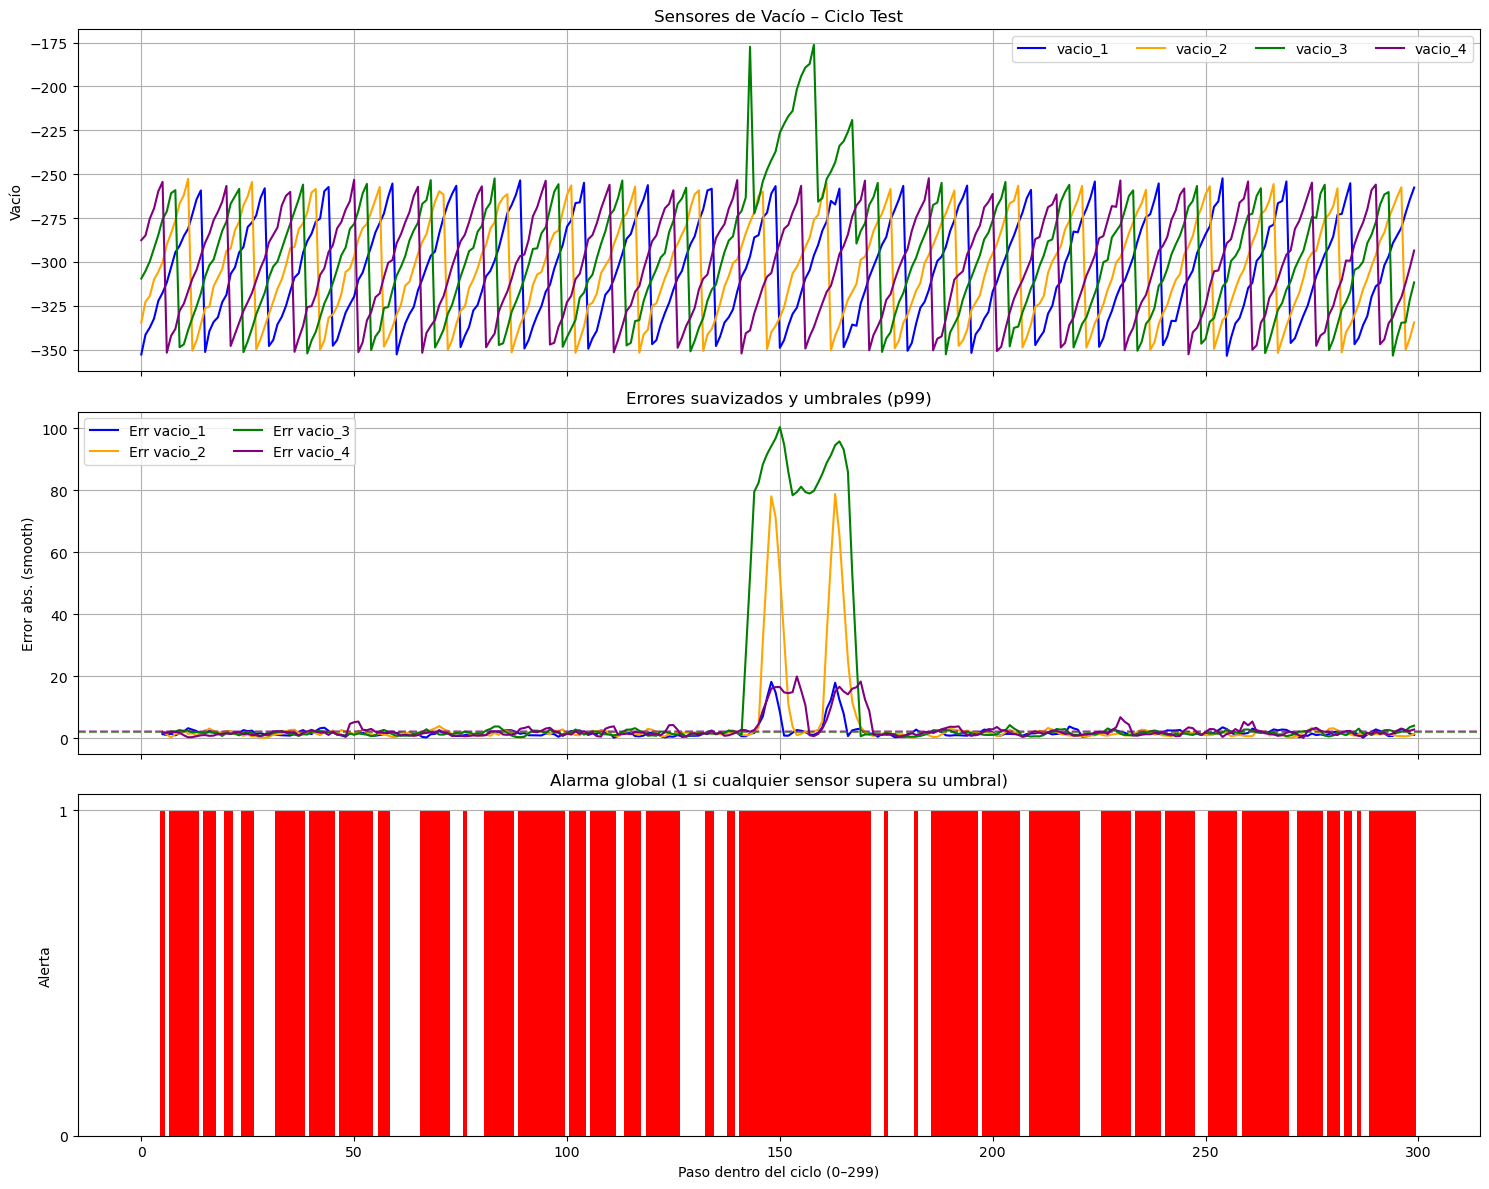

==== RESUMEN ====
Umbral vacio_1: 2.00
Umbral vacio_2: 1.99
Umbral vacio_3: 2.01
Umbral vacio_4: 2.28
Puntos con alerta global: 218 / 295
⚠️  Primera alerta en paso 5 del ciclo (t<=3 pasos de latencia)


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.ndimage import uniform_filter1d

"""
Detección temprana de fugas / rotura de bolsa usando **4 sensores de vacío** de la pieza.
-------------------------------------------------------------------------------
- Cada ciclo dura 300 pasos.
- Entrenamos con N ciclos saludables.
- Para cada sensor de vacío entrenamos un **modelo independiente** que aprende a
  predecir su propio valor usando:
    * presiones actuales (autoclave)
    * temperatura actual
    * lags de todas las señales (vacíos, presión, temperatura)
- Alerta si **cualquiera** de los 4 errores suavizados supera su umbral
  (percentil 99 de su propio error de entrenamiento) durante ≥ 3 pasos.

Cambia la sección «CARGA DE DATOS REALES» para tus ciclos históricos.
"""

# -----------------------------------------------------------------------------
# 1. PARÁMETROS
# -----------------------------------------------------------------------------
np.random.seed(42)
POINTS_PER_CYCLE   = 300
N_CYCLES_TRAIN     = 20   # ciclos normales para entrenar
N_CYCLES_TEST      = 1    # ciclo bajo vigilancia
NLAGS              = 5    # lags por variable
PERCENTILE_THRESH  = 99   # p99 del error → umbral
SMOOTH_WINDOW      = 3    # nº pasos para media móvil del error

VACIO_COLS   = [f"vacio_{i+1}" for i in range(4)]
AUX_COLS     = ["presion", "temperatura"]
ALL_COLS     = VACIO_COLS + AUX_COLS

# -----------------------------------------------------------------------------
# 2. GENERAR DATOS SINTÉTICOS (reemplazar por carga real)
# -----------------------------------------------------------------------------

def saw_wave(t, period, amp):
    return amp * (2 * (t % period) / period - 1)


def generate_cycle(cycle_id: int, is_good=True, leak_pos=None):
    t = np.arange(POINTS_PER_CYCLE)

    # Presión autoclave: diente de sierra lento + deriva leve
    presion =  5 + saw_wave(t, 60, 20) + 0.02 * t / POINTS_PER_CYCLE
    # Temperatura: responde de forma no lineal a la presión
    temperatura = 60 + np.abs(presion) * 0.5 + np.random.normal(0, 0.3, POINTS_PER_CYCLE)

    # 4 sensores de vacío: oscilan con bombas
    vacios = []
    for i in range(4):
        base = -300 + saw_wave(t + i*3, 15, 50)  # pequeños desfases
        vacios.append(base + np.random.normal(0, 2, POINTS_PER_CYCLE))
    vacios = np.array(vacios)

    # Fuga localizada
    if not is_good and leak_pos is not None:
        end = min(leak_pos + 25, POINTS_PER_CYCLE)
        vacios[2, leak_pos:end] += 80   # p. ej. vacio_3 se deteriora
        temperatura[leak_pos:end]  +=  5  # la pieza se recalienta por mala extracción

    data = {
        "cycle_id"   : cycle_id,
        "t_in_cycle": t,
        "presion"   : presion,
        "temperatura": temperatura,
    }
    for i, col in enumerate(VACIO_COLS):
        data[col] = vacios[i]
    return pd.DataFrame(data)

train_cycles = [generate_cycle(cid, is_good=True) for cid in range(N_CYCLES_TRAIN)]
df_train = pd.concat(train_cycles, ignore_index=True)

leak_pos = np.random.randint(20, POINTS_PER_CYCLE-40)
df_test  = generate_cycle(N_CYCLES_TRAIN, is_good=False, leak_pos=leak_pos)

# -----------------------------------------------------------------------------
# 3. CREAR LAGS SIN CRUZAR CICLOS
# -----------------------------------------------------------------------------

def add_multivar_lags(df: pd.DataFrame, cols: list[str], nlags: int):
    out = df.copy()
    for col in cols:
        for k in range(1, nlags+1):
            out[f"{col}_lag_{k}"] = out.groupby("cycle_id")[col].shift(k)
    return out.dropna()

df_train_lags = add_multivar_lags(df_train, ALL_COLS, NLAGS)
df_test_lags  = add_multivar_lags(df_test,  ALL_COLS, NLAGS)

# -----------------------------------------------------------------------------
# 4. ENTRENAR UN MODELO POR SENSOR
# -----------------------------------------------------------------------------
models      = {}
thresholds  = {}

feature_cols = []
for col in ALL_COLS:
    feature_cols += [f"{col}_lag_{k}" for k in range(1, NLAGS+1)]
feature_cols += AUX_COLS  # presion y temperatura actuales

for vac_col in VACIO_COLS:
    X_train = df_train_lags[feature_cols].values
    y_train = df_train_lags[vac_col].values

    rf = RandomForestRegressor(n_estimators=250, max_depth=None, n_jobs=-1)
    rf.fit(X_train, y_train)

    err = np.abs(y_train - rf.predict(X_train))
    thr = np.percentile(err, PERCENTILE_THRESH)

    models[vac_col]     = rf
    thresholds[vac_col] = thr

# -----------------------------------------------------------------------------
# 5. PREDICCIÓN EN EL CICLO DE TEST + MÉTRICA DE ERROR
# -----------------------------------------------------------------------------
X_test = df_test_lags[feature_cols].values
idx_test = df_test_lags[["t_in_cycle"]]
err_dict = {}
alert_mask_global = np.zeros(len(df_test_lags), dtype=bool)

for vac_col in VACIO_COLS:
    y_true = df_test_lags[vac_col].values
    y_hat  = models[vac_col].predict(X_test)
    err    = np.abs(y_true - y_hat)
    err_smooth = uniform_filter1d(err, size=SMOOTH_WINDOW, mode="nearest")

    err_dict[vac_col] = err_smooth
    alert_mask = err_smooth > thresholds[vac_col]
    alert_mask_global |= alert_mask

first_alert_step = idx_test["t_in_cycle"][alert_mask_global].iloc[0] if alert_mask_global.any() else None

# -----------------------------------------------------------------------------
# 6. VISUALIZACIÓN DEL CICLO DE TEST
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
cycle_t = df_test["t_in_cycle"].values

# (a) Vacíos
for col, color in zip(VACIO_COLS, ["blue", "orange", "green", "purple"]):
    axes[0].plot(cycle_t, df_test[col], label=col, color=color)
axes[0].set_ylabel("Vacío")
axes[0].set_title("Sensores de Vacío – Ciclo Test")
axes[0].legend(ncol=4); axes[0].grid(True)

# (b) Error suavizado y umbral por sensor
for col, color in zip(VACIO_COLS, ["blue", "orange", "green", "purple"]):
    axes[1].plot(idx_test["t_in_cycle"], err_dict[col], color=color, label=f"Err {col}")
    axes[1].axhline(thresholds[col], color=color, linestyle="--", alpha=0.4)
axes[1].set_ylabel("Error abs. (smooth)")
axes[1].set_title("Errores suavizados y umbrales (p99)")
axes[1].grid(True); axes[1].legend(loc="upper left", ncol=2)

# (c) Indicador global de alerta
axes[2].bar(idx_test["t_in_cycle"], alert_mask_global.astype(int), width=1, color="red")
axes[2].set_ylabel("Alerta")
axes[2].set_xlabel("Paso dentro del ciclo (0–299)")
axes[2].set_title("Alarma global (1 si cualquier sensor supera su umbral)")
axes[2].set_yticks([0, 1])
axes[2].grid(True, axis="y")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. RESUMEN EN CONSOLA
# -----------------------------------------------------------------------------
print("==== RESUMEN ====")
for col in VACIO_COLS:
    print(f"Umbral {col}: {thresholds[col]:.2f}")
print(f"Puntos con alerta global: {alert_mask_global.sum()} / {len(alert_mask_global)}")
if first_alert_step is not None:
    print(f"⚠️  Primera alerta en paso {first_alert_step} del ciclo (t<={SMOOTH_WINDOW} pasos de latencia)")
else:
    print("Sin alertas detectadas en el ciclo de test")
